This is explanation for `main.py`. [click here](https://github.com/pian13131/Data-Analysis-for-Trending-Youtube-Videos/blob/master/src/main.py)  
Codes of each group member are in seperate `.py` files such as `time.py`, `views.py` and so on, and then finally integrate into functions in `main.py`.

# main.py

## 1. Code Preview

Use `pandas` and `numpy` to deal with data, and `pyplot` from `matplotlib` and `seaborn` to plot.  
Create a class named `VideoManager` to combine codes of all group members.  
In `__init__()`, we store information such as file path, static data that can be used many times. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json


class VideoManager:
    def __init__(self):
        self.data_root = '../datasets/'
        self.countries = ['CA', 'DE', 'FR', 'GB', 'US']
        self.full_name = {'CA': 'Canada', 'DE': 'Germany',
                          'FR': 'France', 'GB': 'Great British', 'US': 'USA'}
        self.cat_dict = self.get_cat_dict()

    def load_data(self):
        '''
        Load video data into `self.dataset` and prepare for plotting.

        :return: None
        '''
        dataset = {}
        for country in self.countries:
            file_path = self.data_root + country + 'videos.csv'
            raw_df = pd.read_csv(file_path)
            dataset[country] = raw_df
        self.dataset = dataset

    def get_cat_dict(self):
        '''
        Get the dictionary which maps category_id to category name.

        :return: dict
        '''
        cat_dict = {}
        for country in self.countries:
            with open(self.data_root + country + '_category_id.json', 'r') as file:
                json_obj = json.load(file)
            for item in json_obj['items']:
                cat_dict[int(item['id'])] = item['snippet']['title']
        return cat_dict

    def total_views(self):
        '''
        Show number of views in different countries in different categories 
        '''
        result_view = pd.DataFrame()
        for area in self.countries:
            # read csv file and get specific column
            # Combine rows with same category_id
            df_view = pd.DataFrame(self.dataset[area][['category_id', 'views']]).groupby('category_id')[
                'views'].sum().rename('Views in Different Areas').reset_index()
            df_view['Areas'] = self.full_name[area]
            result_view = result_view.append(df_view)

        # Add one new column: `Categories`
        result_view.insert(loc=1, column='Categories',
                           value=result_view.category_id.map(lambda x: self.cat_dict[x]))

        # Add one new column `Total Views` of 5 areas.
        result_view['Total Views'] = result_view.groupby(
            'category_id')['Views in Different Areas'].transform('sum')

        # Sort total views in descending order.
        result_view = result_view.sort_values(
            by='Total Views', ascending=False).reset_index(drop=True).reset_index()

        # Increase font scale.
        sns.set(font_scale=1.3)
        sbplt_fig_view, sbplt_ax_view = plt.subplots()

        # Plot area views at sbplt_ax_view.
        fig_view1 = sns.catplot(x="Categories", y="Views in Different Areas", data=result_view.head(35), hue="Areas",
                                hue_order=['Canada', 'France',
                                           'Germany', 'Great British', 'USA'],
                                kind="bar", palette="muted", edgecolor="1", alpha=0.85, legend_out=False,
                                ax=sbplt_ax_view)

        # Plot total views at sbplt_ax_view2 which is twin ax of sbplt_ax_view.
        sbplt_ax_view2 = sbplt_ax_view.twinx()
        fig_view2 = sns.catplot(x="Categories", y="Total Views", data=result_view.head(35),
                                kind='point', color="b", ax=sbplt_ax_view2)

        # Set figure
        sbplt_ax_view.set_title(
            "Views in different categories and areas", fontsize=30)
        sbplt_ax_view.grid(None)

    def videos_time(self):
        '''
        Show the fluctuation publishing videos in 24 Hours within 5 different area
        '''
        dic = {}
        for e in self.dataset:
            # extract the hour from dataframe
            p_time = [int(x[11:13])
                      for x in list(self.dataset[e].publish_time)]
            video_counter = [0] * 24
            for j in p_time:  # count the videos in each hour
                video_counter[j] += 1
            dic[e] = video_counter  # add the timetable into dictionary
        frame = pd.DataFrame(dic)
        sns.set(font_scale=1.5)
        sns.set(style="whitegrid")
        fig = sns.lineplot(data=frame, palette="tab10", linewidth=1.5)
        fig.set_title('Publishing Videos in 24 Hours')
        fig.set_xlabel('Hours')
        fig.set_ylabel('Publishing Videos')
        plt.xticks(np.arange(0, 24, 1))
        plt.yticks(np.arange(0, 7000, 1000))

    def comment_views(self):
        '''
        Show which video genres viewers are most likely to post comments on.
        '''
        dataframe = pd.DataFrame()
        for country in self.countries:
            # choose 3 columns that will be useful.
            raw_df = self.dataset[country][[
                'category_id', 'views', 'comment_count']]
            df = raw_df.groupby('category_id')[
                ['views', 'comment_count']].sum().reset_index()
            # insert a new column representing comment/view ratio.
            df['Comment/View Ratio'] = df['comment_count'] / df['views']
            df['Country'] = self.full_name[country]
            # insert a new column representing the region a video belongs to.
            dataframe = dataframe.append(df)

        dataframe['Total Ratio'] = dataframe.groupby(
            'category_id')['Comment/View Ratio'].transform('sum')
        dataframe.insert(loc=1, column='Category', value=dataframe.category_id.map(
            lambda id: self.cat_dict[id]))
        # sort categories based on the total ratio of comment to views, in descending order.
        dataframe = dataframe.sort_values(
            by='Total Ratio', ascending=False).reset_index(drop=True).reset_index()

        sns.set(font_scale=0.8)
        fig1, ax1 = plt.subplots()
        # specify how many categories are shown
        cat_count = 5
        hist_count = cat_count * 5

        fig_area = sns.catplot(x="Category", y="Comment/View Ratio", data=dataframe.head(hist_count),
                               hue="Country",
                               hue_order=['Canada', 'France',
                                          'Germany', 'Great British', 'USA'],
                               kind="bar", palette="muted", edgecolor="1", alpha=0.85, legend_out=False, ax=ax1)

        ax2 = ax1.twinx()
        fig_total = sns.catplot(x="Category", y="Total Ratio", data=dataframe.head(hist_count),
                                kind='point', color="b", ax=ax2)

        ax1.set_title("Comment/View Ratio of Different Genres and Countries", fontsize=30)
        # ax1.set_xticklabels(rotation=30)
        ax1.grid(None)

    def likes(self):
        '''
        Show which video categories have the highest like/dislike ratio.
        '''
        dataframe = pd.DataFrame()
        for country in self.countries:
            raw_df = self.dataset[country][[
                'category_id', 'likes', 'dislikes']]
            df = raw_df.groupby('category_id')[
                ['likes', 'dislikes']].sum().reset_index()
            df['Likes/Dislikes Ratio'] = df['likes'] / df['dislikes']
            df['Country'] = self.full_name[country]
            dataframe = dataframe.append(df)

        dataframe['Average_Ratio'] = dataframe.groupby(
            'category_id')['Likes/Dislikes Ratio'].transform('sum') / 5
        dataframe.insert(loc=1, column='Category', value=dataframe.category_id.map(
            lambda id: self.cat_dict[id]))
        # dataframe.insert(loc=1, column='Dif to One', value=dataframe.Average_Ratio.map(lambda r: abs(r - 1)))
        dataframe = dataframe.sort_values(
            by='Average_Ratio', ascending=False).reset_index(drop=True).reset_index()

        sns.set(font_scale=0.8)
        fig1, ax1 = plt.subplots()
        cat_count = 10
        hist_count = cat_count * 5

        fig_area = sns.catplot(x="Category", y="Likes/Dislikes Ratio", data=dataframe.head(hist_count),
                               hue="Country",
                               hue_order=['Canada', 'France',
                                          'Germany', 'Great British', 'USA'],
                               kind="bar", palette="muted", edgecolor="1", alpha=0.85, legend_out=False, ax=ax1)

        ax2 = ax1.twinx()
        fig_total = sns.catplot(x="Category", y="Average_Ratio", data=dataframe.head(hist_count),
                                kind='point', color="b", ax=ax2)

        ax1.set_title(
            "Likes/Dislikes Ratio of Different Genres and Countries", fontsize=30)
        ax1.grid(None)

    def controversial(self):
        '''
        Show the most controversial video genres.
        '''
        dataframe = pd.DataFrame()
        for country in self.countries:
            # choose 3 columns that might be useful
            raw_df = self.dataset[country][[
                'category_id', 'likes', 'dislikes']]
            df = raw_df.groupby('category_id')[
                ['likes', 'dislikes']].sum().reset_index()
            # insert a new column representing like/dislike ratio
            df['Likes/Dislikes Ratio'] = df['likes'] / df['dislikes']
            df['Country'] = self.full_name[country]
            dataframe = dataframe.append(df)

        # insert a new column representing the average ratio of a video category
        dataframe['Average_Ratio'] = dataframe.groupby(
            'category_id')['Likes/Dislikes Ratio'].transform('sum') / 5
        dataframe.insert(loc=1, column='Category', value=dataframe.category_id.map(
            lambda id: self.cat_dict[id]))
        dataframe.insert(loc=1, column='Dif to One',
                         value=dataframe.Average_Ratio.map(lambda r: abs(r - 1)))
        dataframe = dataframe.sort_values(
            by='Dif to One', ascending=True).reset_index(drop=True).reset_index()

        sns.set(font_scale=0.8)
        fig1, ax1 = plt.subplots()
        # specify how many categories are shown
        cat_count = 5
        hist_count = cat_count * 5
        fig_area = sns.catplot(x="Category", y="Likes/Dislikes Ratio",
                               data=pd.DataFrame(pd.concat([dataframe.iloc[2:17], dataframe.iloc[20:50]])),
                               hue="Country", hue_order=['Canada', 'France',
                                                         'Germany', 'Great British',
                                                         'USA'], kind="bar", palette="muted", edgecolor="1", alpha=0.85,
                               legend_out=False, ax=ax1)
        ax2 = ax1.twinx()
        fig_total = sns.catplot(x="Category", y="Average_Ratio",
                                data=pd.DataFrame(pd.concat([dataframe.iloc[2:17], dataframe.iloc[20:50]])), kind='point',
                                color="b", ax=ax2)

        ax1.set_title("Likes/Dislikes Ratio of Different Genres and Countries", fontsize=30)

        ax1.grid(None)


    def show_plot(self):
        '''
        Plot and show all results from different topics of our project.

        :return: None
        '''
        plt.xticks(rotation=45)
        plt.show()

#### Initialize the class `VideoManager`.

In [2]:
vm = VideoManager()
vm.load_data()

## 2. Explanation

In function `load_data()`, we load data from all `.csv` into `self.dataset` such that we can use them repeatedly without loading again.

In [3]:
def load_data(self):
    '''
    Load video data into `self.dataset` and prepare for plotting.

    :return: None
    '''
    dataset = {}
    for country in self.countries:
        file_path = self.data_root + country + 'videos.csv'
        raw_df = pd.read_csv(file_path)
        dataset[country] = raw_df
    self.dataset = dataset

In function `get_cat_dict()`, we get the dictionary which maps `category_id` to corresponding category name, and store it to `self.cat_dict` so that we can get easily to the name of category.

In [4]:
def get_cat_dict(self):
    '''
    Get the dictionary which maps category_id to category name.

    :return: dict
    '''
    cat_dict = {}
    for country in self.countries:
        with open(self.data_root + country + '_category_id.json', 'r') as file:
            json_obj = json.load(file)
        for item in json_obj['items']:
            cat_dict[int(item['id'])] = item['snippet']['title']
    return cat_dict

In function `show_polt()`, visualize results from different topics of our project.

In [5]:
def show_plot(self):
    '''
    Plot and show all results from different topics of our project.

    :return: None
    '''
    plt.xticks(rotation=45)
    plt.show()

## 2-1. Publishing time

For this part, we extract the hour information from dataframe, and use a loop to count the publishing videos number of each time clock and country. Then use `lineplot` from `seaborn` to plot the whole fluctuation figure.

In [6]:
def videos_time(self):
    '''
    Show the fluctuation publishing videos in 24 Hours within 5 different area
    '''
    dic = {}
    for e in self.dataset:
        # extract the hour from dataframe
        p_time = [int(x[11:13])
                  for x in list(self.dataset[e].publish_time)]
        video_counter = [0] * 24
        for j in p_time:  # count the videos in each hour
            video_counter[j] += 1
        dic[e] = video_counter  # add the timetable into dictionary
    frame = pd.DataFrame(dic)
    sns.set(font_scale=1.5)
    sns.set(style="whitegrid")
    fig = sns.lineplot(data=frame, palette="tab10", linewidth=1.5)
    fig.set_title('Publishing Videos in 24 Hours')
    fig.set_xlabel('Hours')
    fig.set_ylabel('Publishing Videos')
    plt.xticks(np.arange(0, 24, 1))
    plt.yticks(np.arange(0, 7000, 1000))

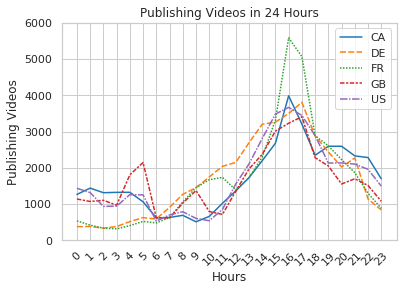

In [7]:
vm.videos_time()
vm.show_plot()

## 2-2. Views in different countries in different categories
First of all, extract required columns from the `sel.dataset`, and group by `category_id` as well as sum up the views in different categories. Repeat this for each country.  

Then, add new column named `Categories` to store name of category corresponding to its id. Also, create new column called `Total Views` to store total views of each category, and sort by total views in descending order. 

Utilize `catplot` from `seaborn`, to plot views from different countries for different categories. Use its twin ax to plot total views so that we can combine these two information in one figure.

In [8]:
def total_views(self):
    '''
    Show number of views in different countries in different categories 
    '''
    result_view = pd.DataFrame()
    for area in self.countries:
        # read csv file and get specific column
        # Combine rows with same category_id
        df_view = pd.DataFrame(self.dataset[area][['category_id', 'views']]).groupby('category_id')[
            'views'].sum().rename('Views in Different Areas').reset_index()
        df_view['Areas'] = self.full_name[area]
        result_view = result_view.append(df_view)

    # Add one new column: `Categories`
    result_view.insert(loc=1, column='Categories',
                       value=result_view.category_id.map(lambda x: self.cat_dict[x]))

    # Add one new column `Total Views` of 5 areas.
    result_view['Total Views'] = result_view.groupby(
        'category_id')['Views in Different Areas'].transform('sum')

    # Sort total views in descending order.
    result_view = result_view.sort_values(
        by='Total Views', ascending=False).reset_index(drop=True).reset_index()

    # Increase font scale.
    # sns.set(font_scale=1.3)
    sbplt_fig_view, sbplt_ax_view = plt.subplots()

    # Plot area views at sbplt_ax_view.
    fig_view1 = sns.catplot(x="Categories", y="Views in Different Areas", data=result_view.head(35), hue="Areas",
                            hue_order=['Canada', 'France',
                                       'Germany', 'Great British', 'USA'],
                            kind="bar", palette="muted", edgecolor="1", alpha=0.85, legend_out=False,
                            ax=sbplt_ax_view)

    # Plot total views at sbplt_ax_view2 which is twin ax of sbplt_ax_view.
    sbplt_ax_view2 = sbplt_ax_view.twinx()
    fig_view2 = sns.catplot(x="Categories", y="Total Views", data=result_view.head(35),
                            kind='point', color="b", ax=sbplt_ax_view2)

    # Set figure
    sbplt_ax_view.set_title(
        "Views in different categories and areas", fontsize=30)
    sbplt_ax_view.grid(None)

/home/rex/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


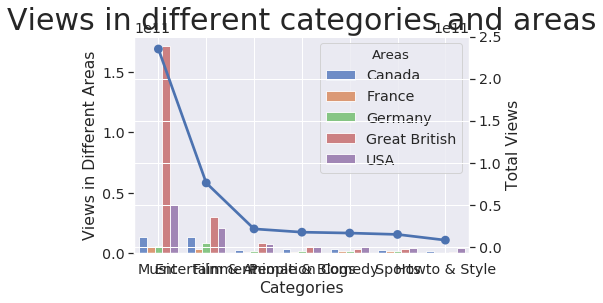

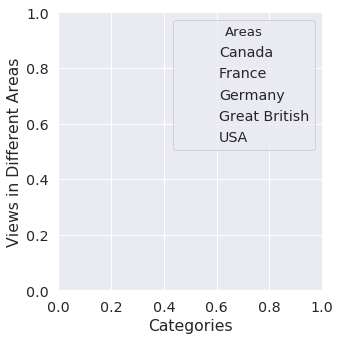

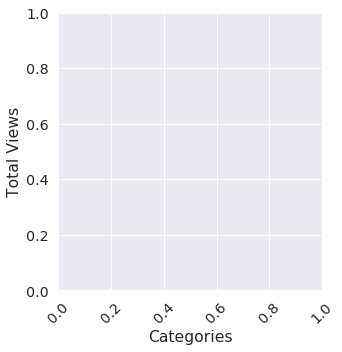

In [9]:
vm.total_views()
vm.show_plot()

## 2-3. Comment ratio
Obtain comment ratio by computing number of comments divided by total views to know people in which country react to what kind of videos.

In [10]:
def comment_views(self):
    '''
    Show which video genres viewers are most likely to post comments on.
    '''
    dataframe = pd.DataFrame()
    for country in self.countries:
        # choose 3 columns that will be useful.
        raw_df = self.dataset[country][[
            'category_id', 'views', 'comment_count']]
        df = raw_df.groupby('category_id')[
            ['views', 'comment_count']].sum().reset_index()
        # insert a new column representing comment/view ratio.
        df['Comment/View Ratio'] = df['comment_count'] / df['views']
        df['Country'] = self.full_name[country]
        # insert a new column representing the region a video belongs to.
        dataframe = dataframe.append(df)

    dataframe['Total Ratio'] = dataframe.groupby(
        'category_id')['Comment/View Ratio'].transform('sum')
    dataframe.insert(loc=1, column='Category', value=dataframe.category_id.map(
        lambda id: self.cat_dict[id]))
    # sort categories based on the total ratio of comment to views, in descending order.
    dataframe = dataframe.sort_values(
        by='Total Ratio', ascending=False).reset_index(drop=True).reset_index()

    sns.set(font_scale=0.8)
    fig1, ax1 = plt.subplots()
    # specify how many categories are shown
    cat_count = 5
    hist_count = cat_count * 5

    fig_area = sns.catplot(x="Category", y="Comment/View Ratio", data=dataframe.head(hist_count),
                           hue="Country",
                           hue_order=['Canada', 'France',
                                      'Germany', 'Great British', 'USA'],
                           kind="bar", palette="muted", edgecolor="1", alpha=0.85, legend_out=False, ax=ax1)

    ax2 = ax1.twinx()
    fig_total = sns.catplot(x="Category", y="Total Ratio", data=dataframe.head(hist_count),
                            kind='point', color="b", ax=ax2)

    ax1.set_title("Comment/View Ratio of Different Genres and Countries", fontsize=30)
    # ax1.set_xticklabels(rotation=30)
    ax1.grid(None)

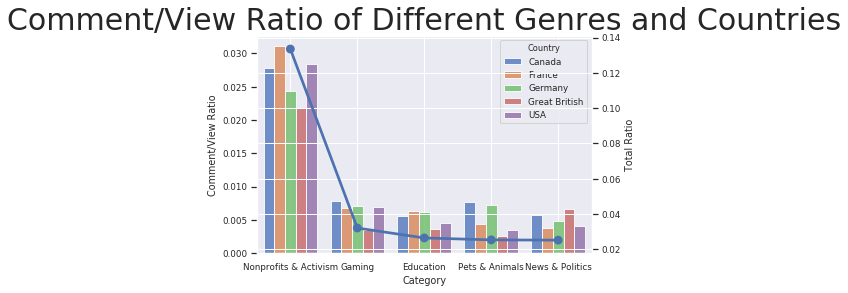

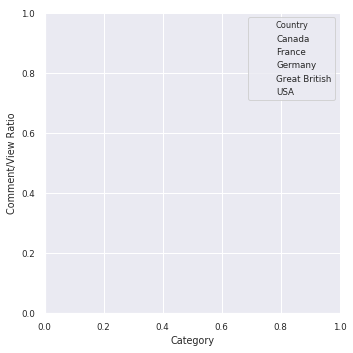

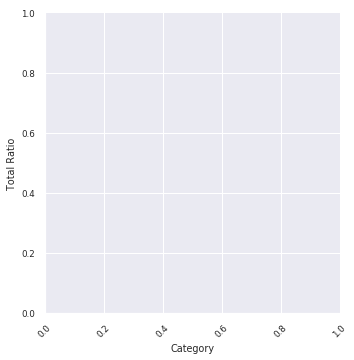

In [11]:
vm.comment_views()
vm.show_plot()

## 2-4. Likes and dislikes
Compute number of likes divided by that of dislikes to know what kind of videos are acceptable and enjoyable the most by the public.  
Sort by the ratio of likes/dislikes in descending order.

In [12]:
def likes(self):
    '''
    Show which video categories have the highest like/dislike ratio.
    '''
    dataframe = pd.DataFrame()
    for country in self.countries:
        raw_df = self.dataset[country][[
            'category_id', 'likes', 'dislikes']]
        df = raw_df.groupby('category_id')[
            ['likes', 'dislikes']].sum().reset_index()
        df['Likes/Dislikes Ratio'] = df['likes'] / df['dislikes']
        df['Country'] = self.full_name[country]
        dataframe = dataframe.append(df)

    dataframe['Average_Ratio'] = dataframe.groupby(
        'category_id')['Likes/Dislikes Ratio'].transform('sum') / 5
    dataframe.insert(loc=1, column='Category', value=dataframe.category_id.map(
        lambda id: self.cat_dict[id]))
    # dataframe.insert(loc=1, column='Dif to One', value=dataframe.Average_Ratio.map(lambda r: abs(r - 1)))
    dataframe = dataframe.sort_values(
        by='Average_Ratio', ascending=False).reset_index(drop=True).reset_index()

    sns.set(font_scale=0.8)
    fig1, ax1 = plt.subplots()
    cat_count = 10
    hist_count = cat_count * 5

    fig_area = sns.catplot(x="Category", y="Likes/Dislikes Ratio", data=dataframe.head(hist_count),
                           hue="Country",
                           hue_order=['Canada', 'France',
                                      'Germany', 'Great British', 'USA'],
                           kind="bar", palette="muted", edgecolor="1", alpha=0.85, legend_out=False, ax=ax1)

    ax2 = ax1.twinx()
    fig_total = sns.catplot(x="Category", y="Average_Ratio", data=dataframe.head(hist_count),
                            kind='point', color="b", ax=ax2)

    ax1.set_title(
        "Likes/Dislikes Ratio of Different Genres and Countries", fontsize=30)
    ax1.grid(None)

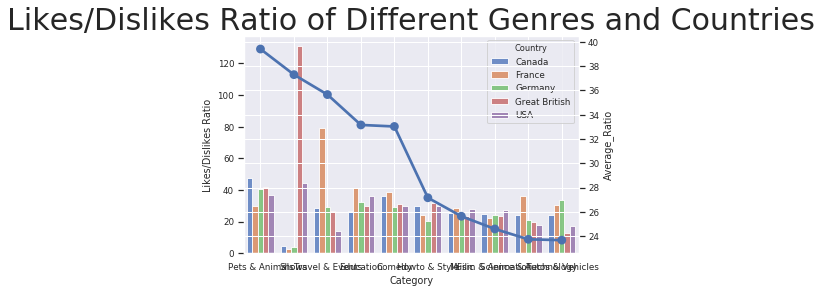

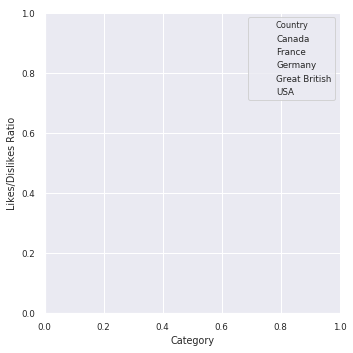

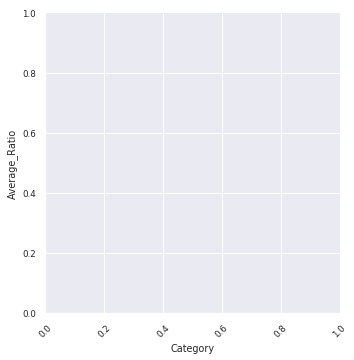

In [13]:
vm.likes()
vm.show_plot()

## 2-5. Controversial
We say a video is controversial by looking at its ratio of likes/dislikes. What's difference is that we compute the absolute value of one minus the ratio. This is because a video with a very high or very low ratio represents that it is kind of controversial, especially when ratio of likes/dislikes is extremely low.

In [14]:
def controversial(self):
    '''
    Show the most controversial video genres.
    '''
    dataframe = pd.DataFrame()
    for country in self.countries:
        # choose 3 columns that might be useful
        raw_df = self.dataset[country][[
            'category_id', 'likes', 'dislikes']]
        df = raw_df.groupby('category_id')[
            ['likes', 'dislikes']].sum().reset_index()
        # insert a new column representing like/dislike ratio
        df['Likes/Dislikes Ratio'] = df['likes'] / df['dislikes']
        df['Country'] = self.full_name[country]
        dataframe = dataframe.append(df)

    # insert a new column representing the average ratio of a video category
    dataframe['Average_Ratio'] = dataframe.groupby(
        'category_id')['Likes/Dislikes Ratio'].transform('sum') / 5
    dataframe.insert(loc=1, column='Category', value=dataframe.category_id.map(
        lambda id: self.cat_dict[id]))
    dataframe.insert(loc=1, column='Dif to One',
                     value=dataframe.Average_Ratio.map(lambda r: abs(r - 1)))
    dataframe = dataframe.sort_values(
        by='Dif to One', ascending=True).reset_index(drop=True).reset_index()

    sns.set(font_scale=0.8)
    fig1, ax1 = plt.subplots()
    # specify how many categories are shown
    cat_count = 5
    hist_count = cat_count * 5
    fig_area = sns.catplot(x="Category", y="Likes/Dislikes Ratio",
                           data=pd.DataFrame(pd.concat([dataframe.iloc[2:17], dataframe.iloc[20:50]])),
                           hue="Country", hue_order=['Canada', 'France',
                                                     'Germany', 'Great British',
                                                     'USA'], kind="bar", palette="muted", edgecolor="1", alpha=0.85,
                           legend_out=False, ax=ax1)
    ax2 = ax1.twinx()
    fig_total = sns.catplot(x="Category", y="Average_Ratio",
                            data=pd.DataFrame(pd.concat([dataframe.iloc[2:17], dataframe.iloc[20:50]])), kind='point',
                            color="b", ax=ax2)

    ax1.set_title("Likes/Dislikes Ratio of Different Genres and Countries", fontsize=30)

    ax1.grid(None)

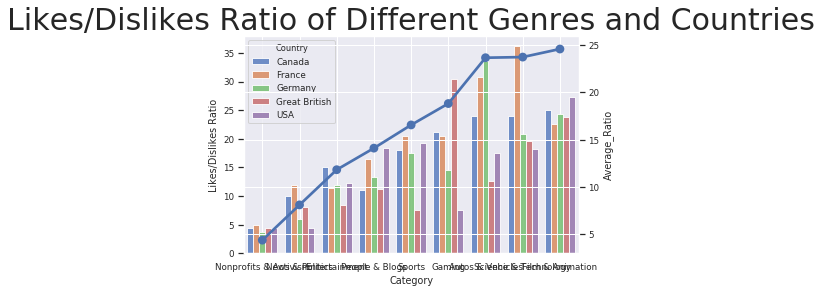

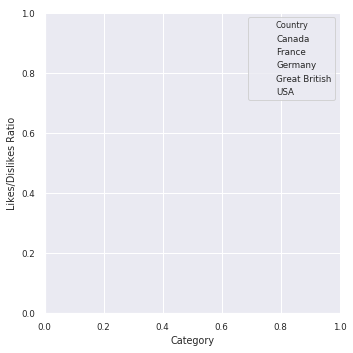

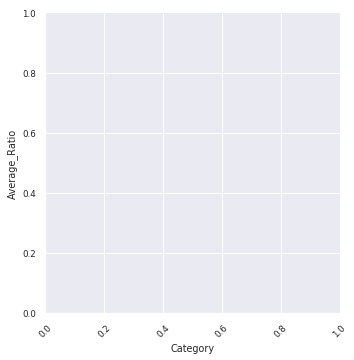

In [15]:
vm.controversial()
vm.show_plot()